# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [11]:
!python --version

Python 3.9.20


In [12]:
!pip install tensorflow-gpu==2.10.1

In [13]:
pip install labelme

Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install --upgrade pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [16]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [22]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [23]:
!labelme

2024-10-27 14:35:38,218 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Rav\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [8]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [18]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [19]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [27]:
images = tf.data.Dataset.list_files('data/images/*.jpg')

In [28]:
images.as_numpy_iterator().next()

b'data\\images\\8ba67007-9442-11ef-a769-f0a654d17968.jpg'

In [39]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [30]:
images = images.map(load_image)

In [31]:
images.as_numpy_iterator().next()

array([[[67, 80, 71],
        [68, 81, 72],
        [68, 81, 72],
        ...,
        [96, 81, 52],
        [97, 81, 56],
        [98, 82, 57]],

       [[66, 79, 70],
        [66, 79, 70],
        [67, 80, 71],
        ...,
        [95, 80, 51],
        [97, 81, 55],
        [97, 81, 56]],

       [[66, 79, 70],
        [66, 79, 70],
        [66, 79, 70],
        ...,
        [95, 81, 52],
        [97, 81, 55],
        [97, 81, 55]],

       ...,

       [[23, 33, 34],
        [24, 34, 35],
        [24, 36, 36],
        ...,
        [36, 37, 32],
        [36, 36, 34],
        [36, 36, 34]],

       [[24, 36, 36],
        [25, 37, 37],
        [26, 37, 39],
        ...,
        [36, 37, 32],
        [36, 37, 32],
        [35, 36, 31]],

       [[25, 37, 37],
        [26, 38, 38],
        [28, 39, 41],
        ...,
        [36, 37, 32],
        [35, 36, 31],
        [34, 35, 30]]], dtype=uint8)

In [32]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [33]:
image_generator = images.batch(4).as_numpy_iterator()

In [34]:
plot_images = image_generator.next()

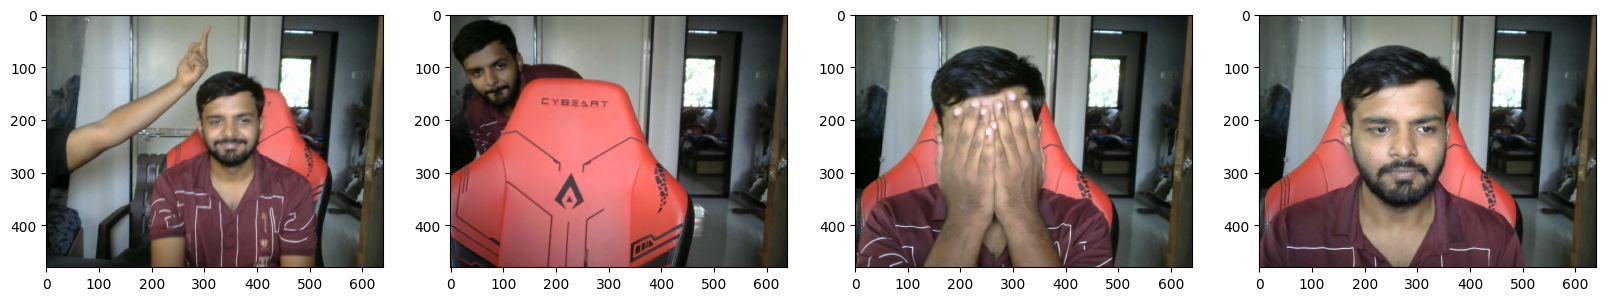

In [35]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [36]:
90*.7 # 63 to train

62.99999999999999

In [37]:
90*.15 # 14 and 13 to test and val

13.5

### 3.2 Move the Matching Labels

In [39]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [9]:
import albumentations as alb

In [22]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [25]:
img = cv2.imread(os.path.join('data','train', 'images','506f491c-9442-11ef-811c-f0a654d17968.jpg'))

In [26]:
with open(os.path.join('data', 'train', 'labels', '506f491c-9442-11ef-811c-f0a654d17968.json'), 'r') as f:
    label = json.load(f)

In [27]:
label['shapes'][0]['points']

[[248.28282828282832, 72.32323232323232],
 [447.27272727272725, 325.35353535353534]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [28]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [29]:
coords

[248.28282828282832, 72.32323232323232, 447.27272727272725, 325.35353535353534]

In [30]:
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.3879419191919192,
 0.15067340067340065,
 0.6988636363636364,
 0.6778198653198653]

### 4.4 Apply Augmentations and View Results

In [31]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [32]:
augmented['bboxes'][0][2:]

[0.8028282674153646, 0.6963411712646485]

In [34]:
augmented['bboxes']

[[0.3606285179985894,
  0.13405163129170736,
  0.8028282674153646,
  0.6963411712646485]]

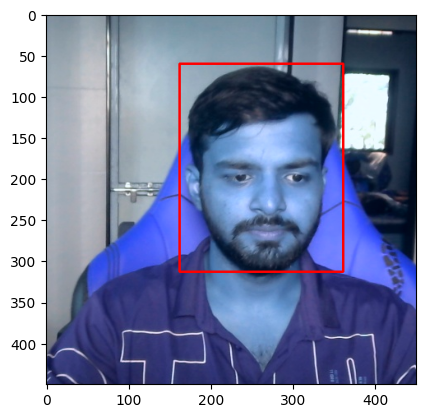

In [35]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [37]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [40]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [41]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [42]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [43]:
train_images.as_numpy_iterator().next()

array([[[0.16507353, 0.18915442, 0.05582108],
        [0.17696078, 0.20588236, 0.07205883],
        [0.17205882, 0.2112745 , 0.07794118],
        ...,
        [0.5470588 , 0.57843137, 0.41764706],
        [0.49246323, 0.5238358 , 0.37775734],
        [0.4194853 , 0.4620711 , 0.32542893]],

       [[0.16813725, 0.19558823, 0.0622549 ],
        [0.17254902, 0.20147058, 0.06764706],
        [0.18045343, 0.21966912, 0.08633579],
        ...,
        [0.5651961 , 0.5887255 , 0.43970588],
        [0.5180147 , 0.54724264, 0.4120098 ],
        [0.5076593 , 0.55226713, 0.41599265]],

       [[0.1627451 , 0.20196079, 0.06470589],
        [0.1764706 , 0.21568628, 0.07892157],
        [0.184375  , 0.22359069, 0.09025735],
        ...,
        [0.5716299 , 0.5951593 , 0.45398283],
        [0.51715684, 0.55490196, 0.41813725],
        [0.581924  , 0.6384191 , 0.5131127 ]],

       ...,

       [[0.28921568, 0.28204656, 0.11482843],
        [0.31905636, 0.2911152 , 0.11715686],
        [0.36807597, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [44]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [45]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [46]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [47]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [48]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.3638, 0.1007, 0.806 , 0.663 ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [49]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

### 7.2 Create Final Datasets (Images/Labels)

In [50]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [51]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [52]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [53]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.4753 , 0.4382 , 0.81   , 0.844  ],
        [0.4565 , 0.1283 , 0.9404 , 0.711  ],
        [0.635  , 0.7427 , 0.927  , 1.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.6377 , 0.08673, 1.     , 0.6807 ],
        [0.1719 , 0.077  , 0.7407 , 0.781  ],
        [0.46   , 0.11414, 0.9    , 0.6987 ],
        [0.     , 0.0536 , 0.554  , 0.811  ]], dtype=float16))

### 7.3 View Images and Annotations

In [54]:
data_samples = train.as_numpy_iterator()

In [55]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


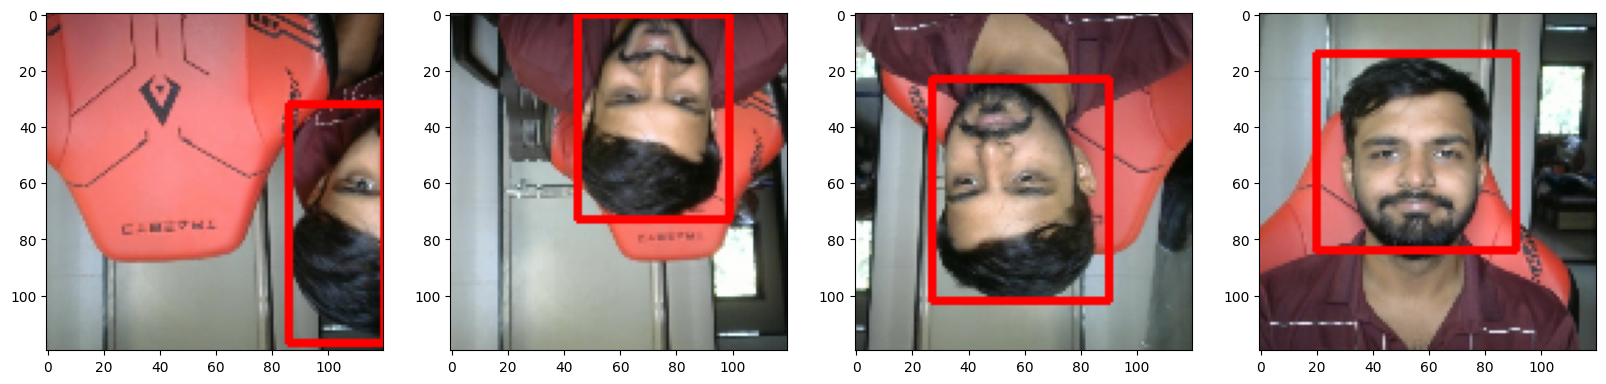

In [57]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    # Make a writable copy of the sample image
    sample_image = res[0][idx].copy()  
    sample_coords = res[1][1][idx]
    
    # Draw the rectangle on the writable copy
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
                  (255, 0, 0), 2)

    # Display the image
    ax[idx].imshow(sample_image) 


# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [58]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [59]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 5s 0us/step


In [60]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [61]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [62]:
facetracker = build_model()

In [63]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [64]:
X, y = train.as_numpy_iterator().next()

In [65]:
X.shape

(8, 120, 120, 3)

In [66]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 [==============================] - 4s 4s/step


(array([[0.22244658],
        [0.37342325],
        [0.31683213],
        [0.36561373],
        [0.34375027],
        [0.2819612 ],
        [0.38322848],
        [0.3539492 ]], dtype=float32),
 array([[0.37032214, 0.6581389 , 0.49058425, 0.51046634],
        [0.47571155, 0.65499717, 0.41988584, 0.5266184 ],
        [0.4085894 , 0.5958249 , 0.42089424, 0.54520845],
        [0.35077125, 0.63932085, 0.43211666, 0.56490594],
        [0.48030832, 0.58356965, 0.40706557, 0.4972822 ],
        [0.4444179 , 0.59666926, 0.5054675 , 0.56155616],
        [0.4595593 , 0.58493555, 0.41879374, 0.5160737 ],
        [0.4478213 , 0.5630517 , 0.39981773, 0.57747394]], dtype=float32))

# 9. Define Losses and Optimizers


### 9.1 Define Optimizer and LR

In [67]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [68]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [69]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [70]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [71]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.321095>

In [72]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9242302>

In [73]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.321095>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [74]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [75]:
model = FaceTracker(facetracker)

In [76]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [77]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [81]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
473/473 [==============================] - 12s 21ms/step - total_loss: 0.0154 - class_loss: 0.0036 - regress_loss: 0.0136 - val_total_loss: 0.0178 - val_class_loss: 1.4318e-04 - val_regress_loss: 0.0177
Epoch 2/20
473/473 [==============================] - 12s 21ms/step - total_loss: 0.0114 - class_loss: 0.0021 - regress_loss: 0.0104 - val_total_loss: 0.0101 - val_class_loss: 4.8578e-06 - val_regress_loss: 0.0101
Epoch 3/20
473/473 [==============================] - 12s 21ms/step - total_loss: 0.0106 - class_loss: 0.0021 - regress_loss: 0.0096 - val_total_loss: 0.0272 - val_class_loss: 7.5748e-04 - val_regress_loss: 0.0268
Epoch 4/20
473/473 [==============================] - 12s 21ms/step - total_loss: 0.0103 - class_loss: 0.0018 - regress_loss: 0.0094 - val_total_loss: 0.0093 - val_class_loss: 6.5417e-06 - val_regress_loss: 0.0093
Epoch 5/20
473/473 [==============================] - 12s 21ms/step - total_loss: 0.0070 - class_loss: 9.7735e-04 - regress_loss: 0.0065 - val_t

### 10.3 Plot Performance

In [84]:
hist.history

{'total_loss': [0.004273572470992804,
  0.0029963930137455463,
  0.0013356450945138931,
  0.000189554164535366,
  0.0004987859283573925,
  0.0016101053915917873,
  0.0006640810752287507,
  0.0009717717184685171,
  0.0012408087495714426,
  0.0022979227360337973,
  0.0014118002727627754,
  0.008805341087281704,
  0.0012762710684910417,
  0.00039058964466676116,
  0.0008127192268148065,
  0.0010064691305160522,
  0.00036472026840783656,
  0.00035726127680391073,
  0.0008936502272263169,
  0.0006028958014212549],
 'class_loss': [1.6451385818072595e-05,
  0.0012038577115163207,
  2.396155468886718e-05,
  2.875930931622861e-06,
  4.5226879592519253e-05,
  8.270276339317206e-06,
  1.7106824088841677e-05,
  3.054791159229353e-05,
  3.5585795558290556e-05,
  3.273862603236921e-05,
  3.905854464392178e-05,
  1.9878571038134396e-05,
  1.2398041690175887e-05,
  2.384186643666908e-07,
  6.794981800339883e-06,
  1.981894274649676e-05,
  6.854540970380185e-07,
  2.2471576812677085e-05,
  1.2367991075

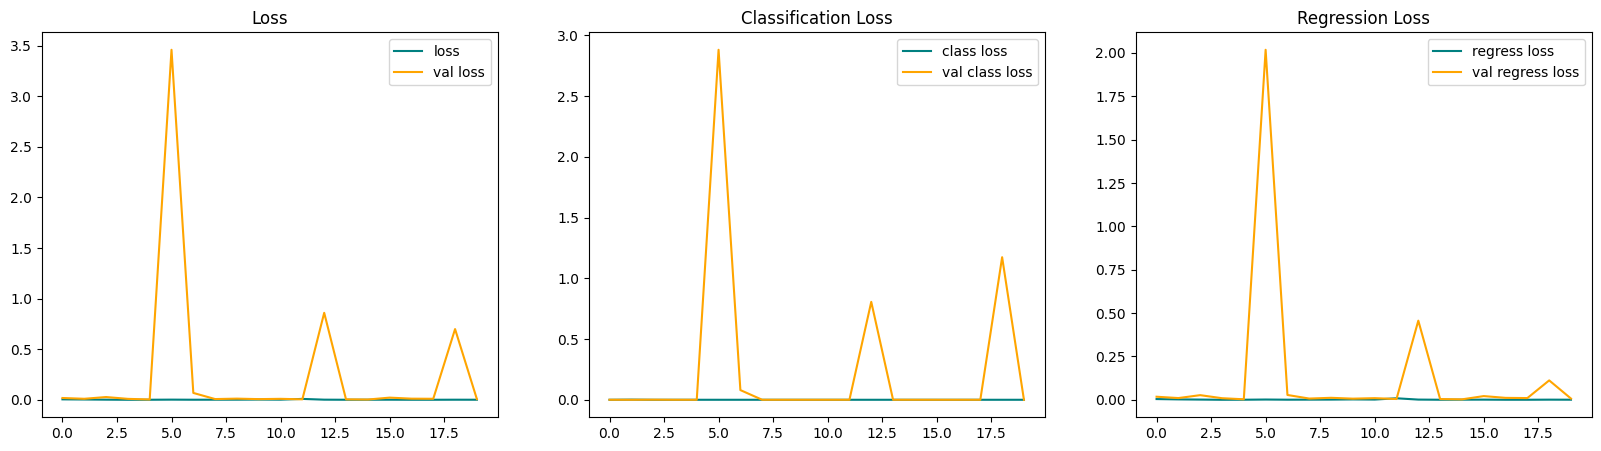

In [85]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions


### 11.1 Make Predictions on Test Set

In [91]:
test_data = test.as_numpy_iterator()

In [101]:
test_sample = test_data.next()

In [102]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


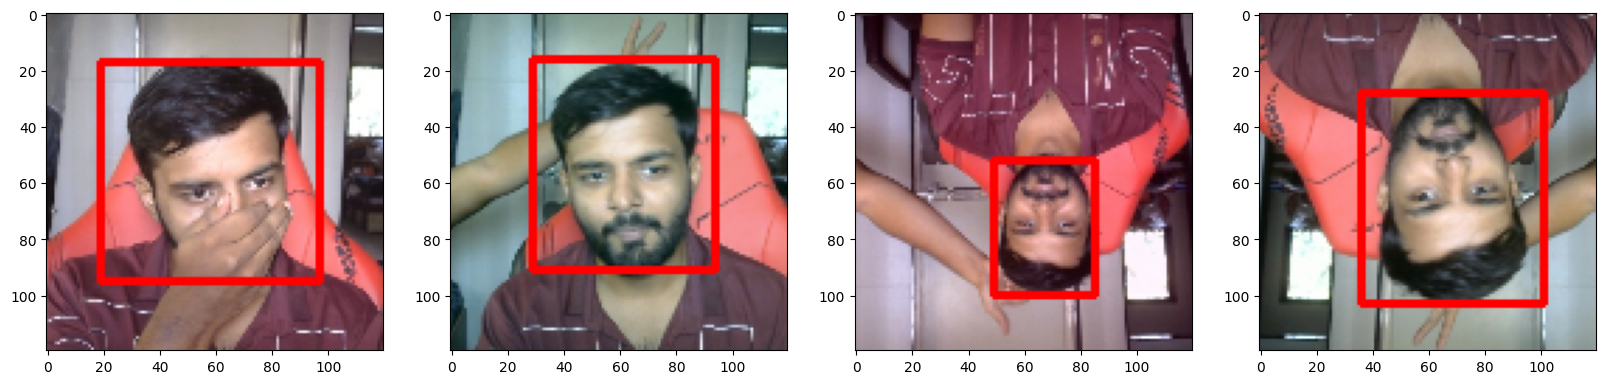

In [103]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx].copy() 
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [1]:
from tensorflow.keras.models import load_model

In [2]:
facetracker.save('facetracker.h5')

NameError: name 'facetracker' is not defined

In [2]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [4]:
from tkinter import Tk, Label
from PIL import Image, ImageTk

# Initialize the face tracking model (make sure it's defined)
# facetracker = YourModelInitializationHere()

# Function to update the frame
def update_frame():
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if ret:
        # Crop the frame (if needed)
        frame = frame[50:500, 50:500]
        
        # Convert frame to RGB and resize for the model
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resized = tf.image.resize(rgb, (120, 120))

        # Predict using your face detection model
        yhat = facetracker.predict(np.expand_dims(resized / 255.0, 0))
        sample_coords = yhat[1][0]

        # Draw rectangles if a face is detected
        if yhat[0] > 0.5:
            cv2.rectangle(frame, 
                          tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)), 
                          (255, 0, 0), 2)
            cv2.putText(frame, 'Face', 
                        tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [0, -5])),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Convert frame to ImageTk format
        imgtk = ImageTk.PhotoImage(image=Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))
        lbl.imgtk = imgtk
        lbl.configure(image=imgtk)

    # Call this function again after 10 milliseconds
    lbl.after(10, update_frame)

# Initialize the video capture
cap = cv2.VideoCapture(0)  # Change to 1 if necessary

# Create a Tkinter window
root = Tk()
root.title("Face Detection")

# Create a label to display the video feed
lbl = Label(root)
lbl.pack()

# Start the frame update loop
update_frame()

# Start the Tkinter event loop
root.mainloop()

# Release the capture on exit
cap.release()


1/1 [==============================] - 0s 14ms/step
